In [1]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import pickle

# Progress bar
from tqdm import tqdm

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as ltb

# Custom classes
import sys
sys.path.insert(0,'..')
from meta_learning import MetaLearner, Model, evaluator
from utils import load_dataset

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## Macros

In [15]:
META_LABEL_METRIC = "kappa"
DATASET = "electricity"
INCLUDE_DRIFT_METRICS = True

BASE_MODEL = RandomForestClassifier
# BASE_MODEL_HYPERPARAMS = {"probability": True}  # SVC
BASE_MODEL_HYPERPARAMS = {"max_depth": 6}  # RandomForest and DecisionTree
# BASE_MODEL_HYPERPARAMS = {}  # Logistic Regression

META_MODEL = ltb.LGBMRegressor
META_MODEL_HYPERPARAMS = {"num_leaves": 21, "max_depth": 5}

FILE_NAME = f"metamodel: {META_MODEL.__name__} - basemodel: {BASE_MODEL.__name__} - metric: {META_LABEL_METRIC} - dataset: {DATASET}"
if INCLUDE_DRIFT_METRICS:
    FILE_NAME += " - with_drift_metrics"
FILE_NAME

'metamodel: LGBMRegressor - basemodel: RandomForestClassifier - metric: kappa - dataset: INSECTS-abrupt_balanced_norm - with_drift_metrics'

In [3]:
# Macros
CLASS_COL = "class"
BASE_MODEL_TYPE = "multiclass"  # multiclass or binary_classification or regression

OFFLINE_PHASE_SIZE = 5000
BASE_TRAIN_SIZE = 2000
R_STATE = 123

ETA = 100  # Window size used to extract meta features (100 for electricity)
STEP = 30  # Step for next meta learning iteration (30 for electricity)
TARGET_DELAY = 500

## Read data

In [4]:
df = load_dataset(DATASET)
print(df.shape)
df.head()

(52848, 34)


,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att25,Att26,Att27,Att28,Att29,Att30,Att31,Att32,Att33,class
0,0.507066,0.153333,0.226092,0.302447,0.007239,0.369120,0.332436,0.017807,0.032819,0.033009,...,0.006855,0.017358,0.013430,0.009138,0.006768,0.007291,0.009224,0.036218,0.162955,2
1,0.281661,0.355953,0.253196,0.340335,0.415631,0.503923,0.392029,0.003648,0.068381,0.011155,...,0.005631,0.014048,0.002431,0.007076,0.037682,0.003089,0.004207,0.004144,0.005044,2
2,0.193750,0.257782,0.183339,0.247017,0.302133,0.363522,0.269729,0.293543,0.293002,0.029522,...,0.023837,0.013922,0.081406,0.413674,0.295615,0.120392,0.036566,0.032652,0.025776,4
3,0.514782,0.154867,0.016903,0.226084,0.297642,0.239111,0.248268,0.066745,0.115020,0.083407,...,0.020949,0.023019,0.021147,0.020813,0.019048,0.011606,0.013379,0.044839,0.123552,2
4,0.774337,0.012549,0.105751,0.033302,0.017170,0.049754,0.173500,0.055220,0.044184,0.034923,...,0.034876,0.060708,0.048119,0.027417,0.015022,0.010218,0.008121,0.012539,0.018058,1


In [5]:
n = df.shape[0]
class_weight = df[CLASS_COL].value_counts().apply(lambda x: x/n).to_dict()
class_weight

{2: 0.16666666666666666,
 4: 0.16666666666666666,
 1: 0.16666666666666666,
 5: 0.16666666666666666,
 0: 0.16666666666666666,
 3: 0.16666666666666666}

In [6]:
# offline
offline_df = df.iloc[:OFFLINE_PHASE_SIZE]
base_train_df = offline_df.iloc[:BASE_TRAIN_SIZE]
meta_train_df = offline_df.iloc[BASE_TRAIN_SIZE:]

# online
online_df = df.iloc[OFFLINE_PHASE_SIZE:]
online_features = online_df.drop(CLASS_COL, axis=1).reset_index(drop=True)
online_targets = online_df[CLASS_COL].reset_index(drop=True)

## Offline stage

In [7]:
base_model = Model(verbose=True, basis_model=BASE_MODEL, hyperparameters=BASE_MODEL_HYPERPARAMS)
meta_model = Model(verbose=True, basis_model=META_MODEL, hyperparameters=META_MODEL_HYPERPARAMS)
learner_params = {
    "base_model": base_model,
    "meta_model": meta_model,
    "base_model_class_column": CLASS_COL,
    "eta": ETA,
    "step": STEP,
    "meta_label_metric": META_LABEL_METRIC,
    "verbose": True,
    "target_delay": TARGET_DELAY,
    "base_model_type": BASE_MODEL_TYPE,
    "include_drift_metrics_mfs": INCLUDE_DRIFT_METRICS,
    }

learner = MetaLearner(**learner_params).fit(base_train_df, meta_train_df)

Training model with instances 0 to 97
Training model with instances 0 to 97


## Online Stage

In [8]:
# start - no target
with tqdm(total=TARGET_DELAY) as pbar:
    for i, row in online_features.iloc[:TARGET_DELAY].iterrows():
        learner.update(row)
        pbar.update(1)

100%|██████████| 500/500 [00:44<00:00, 11.12it/s]


In [9]:
# middle - both target and instances
df = online_features.iloc[TARGET_DELAY:-TARGET_DELAY]

with tqdm(total=df.shape[0]) as pbar:
    for i, row in df.iterrows():
        learner.update(row)
        learner.update_target(online_targets.iloc[i - TARGET_DELAY])
        pbar.update(1)

  2%|▏         | 898/46848 [01:13<43:28, 17.62it/s]  

Training model with instances 30 to 127


  4%|▍         | 1797/46848 [02:25<42:54, 17.50it/s]  

Training model with instances 60 to 157


  6%|▌         | 2698/46848 [03:37<42:06, 17.48it/s]  

Training model with instances 90 to 187


  8%|▊         | 3598/46848 [04:49<40:18, 17.88it/s]  

Training model with instances 120 to 217


 10%|▉         | 4498/46848 [05:59<38:54, 18.14it/s]  

Training model with instances 150 to 247


 12%|█▏        | 5398/46848 [07:09<38:21, 18.01it/s]  

Training model with instances 180 to 277


 13%|█▎        | 6297/46848 [08:19<36:21, 18.58it/s]  

Training model with instances 210 to 307


 15%|█▌        | 7199/46848 [09:28<37:26, 17.65it/s]  

Training model with instances 240 to 337


 17%|█▋        | 8099/46848 [10:39<37:23, 17.27it/s]  

Training model with instances 270 to 367


 19%|█▉        | 8999/46848 [11:51<33:13, 18.99it/s]  

Training model with instances 300 to 397


 21%|██        | 9898/46848 [13:02<43:38, 14.11it/s]  

Training model with instances 330 to 427


 23%|██▎       | 10799/46848 [14:13<32:51, 18.28it/s]  

Training model with instances 360 to 457


 25%|██▍       | 11699/46848 [15:24<32:33, 17.99it/s]  

Training model with instances 390 to 487


 27%|██▋       | 12599/46848 [16:35<32:02, 17.81it/s]  

Training model with instances 420 to 517


 29%|██▉       | 13498/46848 [17:47<31:37, 17.58it/s]  

Training model with instances 450 to 547


 31%|███       | 14399/46848 [18:51<24:47, 21.81it/s]  

Training model with instances 480 to 577


 33%|███▎      | 15299/46848 [19:51<25:09, 20.90it/s]  

Training model with instances 510 to 607


 35%|███▍      | 16199/46848 [20:51<23:36, 21.64it/s]  

Training model with instances 540 to 637


 36%|███▋      | 17099/46848 [21:51<29:20, 16.90it/s]  

Training model with instances 570 to 667


 38%|███▊      | 17999/46848 [22:51<22:21, 21.50it/s]  

Training model with instances 600 to 697


 40%|████      | 18899/46848 [23:52<21:42, 21.45it/s]  

Training model with instances 630 to 727


 42%|████▏     | 19797/46848 [24:53<23:57, 18.82it/s]  

Training model with instances 660 to 757


 44%|████▍     | 20700/46848 [25:54<30:13, 14.42it/s]  

Training model with instances 690 to 787


 46%|████▌     | 21598/46848 [26:54<26:10, 16.07it/s]

Training model with instances 720 to 817


 48%|████▊     | 22499/46848 [1:09:02<28:14, 14.37it/s]      

Training model with instances 750 to 847


 50%|████▉     | 23399/46848 [5:09:11<2:22:30,  2.74it/s]    

Training model with instances 780 to 877


 52%|█████▏    | 24298/46848 [6:24:12<18:18, 20.52it/s]      

Training model with instances 810 to 907


 54%|█████▍    | 25198/46848 [10:18:13<31:21, 11.51it/s]       

Training model with instances 840 to 937


 56%|█████▌    | 26097/46848 [10:19:30<21:45, 15.89it/s]  

Training model with instances 870 to 967


 58%|█████▊    | 26998/46848 [10:21:23<41:24,  7.99it/s]   

Training model with instances 900 to 997


 60%|█████▉    | 27899/46848 [10:22:37<16:10, 19.53it/s]  

Training model with instances 930 to 1027


 61%|██████▏   | 28797/46848 [10:23:44<16:26, 18.30it/s]

Training model with instances 960 to 1057


 63%|██████▎   | 29699/46848 [10:25:16<15:15, 18.74it/s]  

Training model with instances 990 to 1087


 65%|██████▌   | 30599/46848 [10:26:24<13:05, 20.70it/s]

Training model with instances 1020 to 1117


 67%|██████▋   | 31498/46848 [10:27:33<18:18, 13.97it/s]  

Training model with instances 1050 to 1147


 69%|██████▉   | 32398/46848 [10:28:40<12:30, 19.26it/s]  

Training model with instances 1080 to 1177


 71%|███████   | 33297/46848 [10:29:46<11:49, 19.10it/s]

Training model with instances 1110 to 1207


 73%|███████▎  | 34198/46848 [10:30:54<10:39, 19.79it/s]

Training model with instances 1140 to 1237


 75%|███████▍  | 35099/46848 [10:31:59<10:44, 18.23it/s]

Training model with instances 1170 to 1267


 77%|███████▋  | 35998/46848 [10:33:07<09:16, 19.51it/s]

Training model with instances 1200 to 1297


 79%|███████▉  | 36898/46848 [10:34:14<08:39, 19.15it/s]

Training model with instances 1230 to 1327


 81%|████████  | 37799/46848 [10:35:20<07:32, 19.99it/s]

Training model with instances 1260 to 1357


 83%|████████▎ | 38699/46848 [10:36:27<07:03, 19.24it/s]

Training model with instances 1290 to 1387


 85%|████████▍ | 39598/46848 [10:37:35<06:19, 19.11it/s]

Training model with instances 1320 to 1417


 86%|████████▋ | 40498/46848 [10:38:46<05:40, 18.65it/s]

Training model with instances 1350 to 1447


 88%|████████▊ | 41399/46848 [10:39:54<04:36, 19.70it/s]

Training model with instances 1380 to 1477


 90%|█████████ | 42298/46848 [10:41:02<04:29, 16.88it/s]

Training model with instances 1410 to 1507


 92%|█████████▏| 43198/46848 [10:42:30<04:36, 13.18it/s]  

Training model with instances 1440 to 1537


 94%|█████████▍| 44099/46848 [10:44:17<03:17, 13.92it/s]

Training model with instances 1470 to 1567


 96%|█████████▌| 44999/46848 [10:46:15<02:45, 11.20it/s]

Training model with instances 1500 to 1597


 98%|█████████▊| 45898/46848 [10:48:37<01:13, 12.84it/s]

Training model with instances 1530 to 1627


100%|█████████▉| 46799/46848 [10:52:23<00:08,  6.00it/s]

Training model with instances 1560 to 1657


100%|██████████| 46848/46848 [10:52:43<00:00,  1.20it/s]


In [10]:
# end - only targets
with tqdm(total=TARGET_DELAY) as pbar:
    for target in online_targets.tail(TARGET_DELAY):
        learner.update_target(target)
        pbar.update(1)

100%|██████████| 500/500 [00:03<00:00, 135.49it/s]


## Results

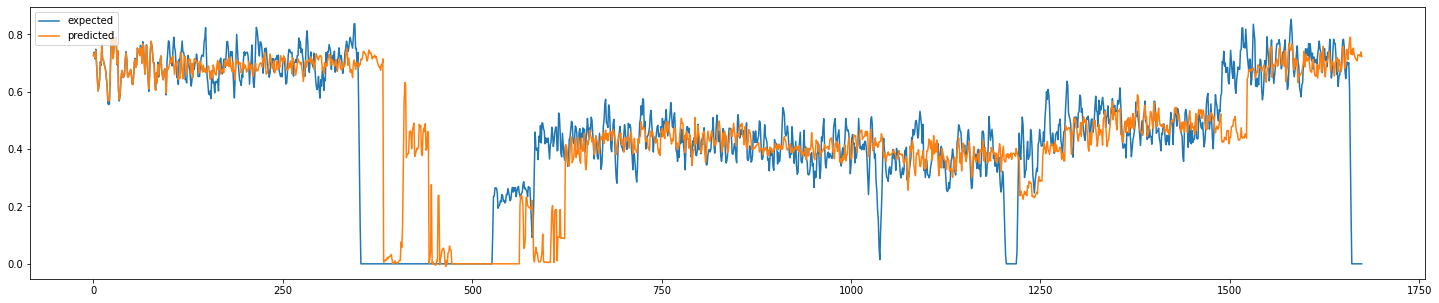

In [11]:
mb = learner.metabase.metabase

y_true = mb[META_LABEL_METRIC]
y_pred = mb['predicted']
x = range(len(y_true))

fig = plt.figure(figsize=(25, 5))
plt.plot(x, y_true, label="expected")
plt.plot(x, y_pred, label="predicted")
plt.legend(loc="upper left")

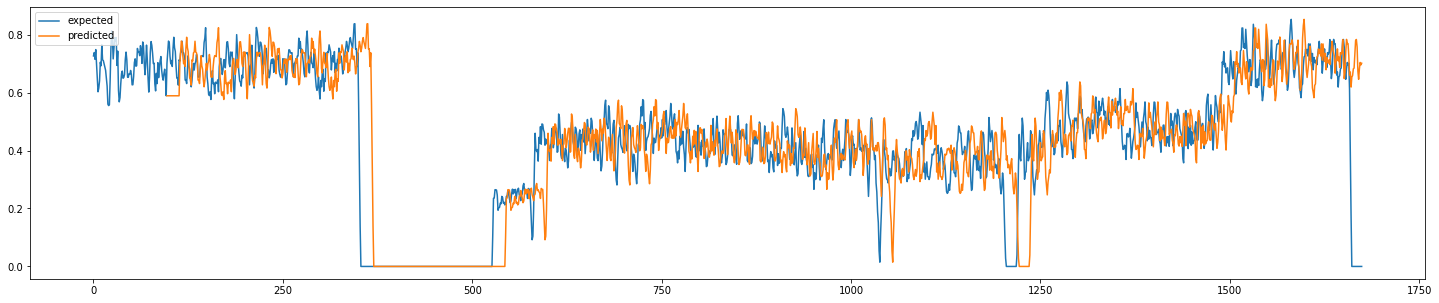

In [12]:
mb = learner.metabase.metabase

y_true = mb[META_LABEL_METRIC]
y_pred = mb[f'last_{META_LABEL_METRIC}']
x = range(len(y_true))

fig = plt.figure(figsize=(25, 5))
plt.plot(x, y_true, label="expected")
plt.plot(x, y_pred, label="predicted")
plt.legend(loc="upper left")

# Save metadata

In [13]:
mb.to_csv(f"metabases/{FILE_NAME}.csv", index=False)

In [14]:
with open(f"models/{FILE_NAME}.pickle", "wb") as handle:
    pickle.dump(learner.meta_model.model, handle, protocol=pickle.HIGHEST_PROTOCOL)